In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [4]:
# MNIST IMAGE --> Tensors
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='/nas-ssd/datasets/MNIST_torchvision', train=True, download=True, transform=transform)

In [5]:
test_data = datasets.MNIST(root='/nas-ssd/datasets/MNIST_torchvision', train=False, download=True, transform=transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /nas-ssd/datasets/MNIST_torchvision
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /nas-ssd/datasets/MNIST_torchvision
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [9]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [10]:
label

5

In [13]:
# plt.imshow(image.reshape((28,28)), cmap='gray') #viridis

In [14]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [15]:
from torchvision.utils import make_grid

np.set_printoptions(formatter=dict(int=lambda x : f'{x:4}')) #formatting

In [16]:
# 1st batch
for images, labels in train_loader:
    break

In [17]:
images.shape

torch.Size([100, 1, 28, 28])

In [18]:
labels.shape

torch.Size([100])

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


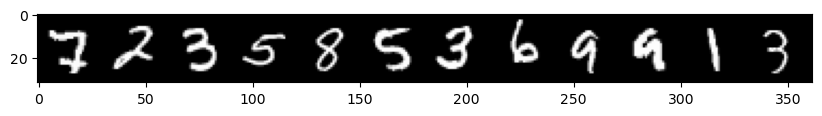

In [19]:
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [20]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84], *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
    
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1) #multi class classification

In [35]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [36]:
# ANN --> CNN
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [37]:
# 105, 214 total parameters

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
images.shape # --> [100, 784]

torch.Size([100, 1, 28, 28])

In [40]:
images.view(100, -1).shape

torch.Size([100, 784])

In [41]:
import time
start_time =  time.time()

#training
epochs = 10

#trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        # 10 neurons
        # [0.1, 0.0, ..., 0.8] --> 9
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            acc = trn_corr.item() * 100 / (100*b)
            print(f'Epoch {i} batch {b} loss: {loss.item()} accuracy: {acc}')
        
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr.detach().numpy())
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr = (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr.detach().numpy())

total_time = time.time() - start_time
print(f'Duration: {total_time / 60} mins')

Epoch 0 batch 200 loss: 0.23541298508644104 accuracy: 83.25
Epoch 0 batch 400 loss: 0.3537280559539795 accuracy: 87.5275
Epoch 0 batch 600 loss: 0.1364523023366928 accuracy: 89.57333333333334
Epoch 1 batch 200 loss: 0.24461664259433746 accuracy: 94.835
Epoch 1 batch 400 loss: 0.14581231772899628 accuracy: 95.0525
Epoch 1 batch 600 loss: 0.07299879193305969 accuracy: 95.35
Epoch 2 batch 200 loss: 0.08550902456045151 accuracy: 96.545
Epoch 2 batch 400 loss: 0.06059926375746727 accuracy: 96.6275
Epoch 2 batch 600 loss: 0.06172012910246849 accuracy: 96.68666666666667
Epoch 3 batch 200 loss: 0.11886222660541534 accuracy: 97.62
Epoch 3 batch 400 loss: 0.057121362537145615 accuracy: 97.4625
Epoch 3 batch 600 loss: 0.03000479005277157 accuracy: 97.49833333333333
Epoch 4 batch 200 loss: 0.11493053287267685 accuracy: 98.135
Epoch 4 batch 400 loss: 0.04807725548744202 accuracy: 98.0125
Epoch 4 batch 600 loss: 0.05257744342088699 accuracy: 98.03666666666666
Epoch 5 batch 200 loss: 0.00851369090378

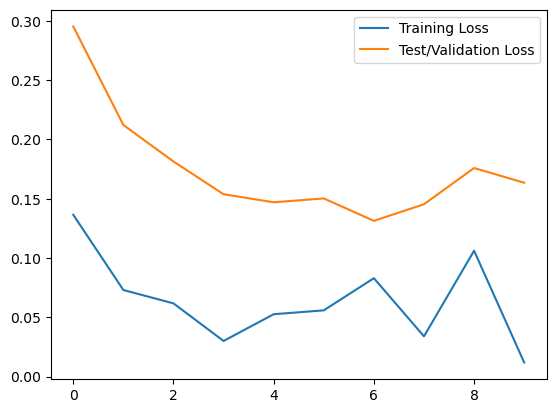

In [42]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test/Validation Loss')
plt.legend()